In [2]:
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix


# Device Setup

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optionally, you can print more details about the GPU if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

Using device: cuda
GPU Name: Tesla T4
Number of GPUs available: 1


# Data Preparation
Still need to create binary label!


In [3]:
def normalize_spectra_by_area(spectrum):
    """
    Normalize a 1D XPS spectrum by area (integral under the curve).
    
    Args:
        spectrum (np.ndarray): 1D array representing the spectrum.
    
    Returns:
        np.ndarray: Normalized spectrum with area under the curve equal to 1.
    """
    # Compute the area under the spectrum (sum of intensities)
    area = np.sum(spectrum)
    
    # Avoid division by zero (if area is zero, return the original spectrum)
    if area == 0:
        return spectrum
    
    # Normalize the spectrum by its area
    normalized_spectrum = spectrum / area
    
    return normalized_spectrum


def fg_checker(label):
    bin_fg_list = []
    for i in range(len(label)):
        if float(label[i]) == 0:
            bin_fg_list.append(0)
        else:
            bin_fg_list.append(1)
    
    return bin_fg_list


def apply_horizontal_shift(spectrum, max_shift):
    '''
    Applies a random horizontal shift to the entire spectrum sequence.
    Args:
        spectrum
        max_shift: maximum number of indices by which the data can shift (set to zero for no shift allowed)
    Returns:
        shifted_spectrum
    '''
    shift = random.randint(-max_shift, max_shift)
    # Create an array of zeros with the same length as the original spectrum
    shifted_spectrum = np.zeros_like(spectrum)

    if shift > 0:
        # Shift to the right
        shifted_spectrum[shift:] = spectrum[:-shift]
    elif shift < 0:
        # Shift to the left
        shifted_spectrum[:shift] = spectrum[-shift:]
    else:
        # No shift, return the original spectrum
        shifted_spectrum = spectrum.copy()

    shifted_spectrum = shifted_spectrum[:len(spectrum)]
    return shifted_spectrum


def gaussian_broadening(spectrum, sigma_sigma):
    '''
    Applies random Gaussian broadening to spectra 
    Args:
        spectrum = input (unbroadened spectrum)
        sigma_sigma = the standard deviation for the distrobution determining sigma for gaussian kernal

    returns:
        broadened_spectrum: spectrum with peak broadening 
    
    '''
    sigma = np.abs(np.random.normal(0, sigma_sigma)) # half normal distribution centered at zero
    convolved_spectrum = gaussian_filter1d(spectrum,sigma)
    return convolved_spectrum


def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

data_path = Path("../data/experimental_data")
CEL_FG_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx')
FG_list = get_label_dict(CEL_FG_path)
FG_list.append('alkane')


class EarlyStopping:
    def __init__(self, patience=30, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def compute_class_metrics(y_true, y_pred, class_names=None):
    """
    Compute performance metrics and confusion matrices for each class.
    
    Args:
        y_true: True labels (n_samples × n_classes)
        y_pred: Predicted labels (n_samples × n_classes)
        class_names: Optional list of class names
        
    Returns:
        metrics_df: DataFrame with class-wise metrics
        confusion_matrices: List of 2x2 confusion matrices
        normalized_matrices: List of row-normalized confusion matrices
    """
    n_classes = y_true.shape[1]
    if class_names is None:
        class_names = [f"Class_{i}" for i in range(n_classes)]
    
    metrics_data = []
    confusion_matrices = []
    normalized_matrices = []
    
    for i, name in enumerate(class_names):
        # Ensure 2x2 matrix even for empty classes
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        confusion_matrices.append(cm)
        
        # Normalize by true labels (rows)
        cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)  # Add small epsilon to avoid divide by zero
        normalized_matrices.append(cm_normalized)
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        metrics_data.append({
            'class': name,
            'true_positives': tp,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'precision': tp / (tp + fp + 1e-10),
            'recall': tp / (tp + fn + 1e-10),
            'f1_score': 2 * tp / (2 * tp + fp + fn + 1e-10),
            'support': tp + fn
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    return metrics_df, confusion_matrices, normalized_matrices

In [38]:
def process_spectra_data(
    spectra_dir: str,
    labels_dir: str,
    max_shift: float = 0,
    max_broadening_sigma: float = 2.0,
    valence_range: float = 0,  #already removed for saved spectra
    energy_resolution: float = 0.1,
    test_size: float = 0.2,
    random_state: int = 42,
    batch_size: int = 64
):
    """
    
    Args:
        spectra_dir (str): Path to directory containing spectral data files
        labels_dir (str): Path to directory containing label files
        max_shift (float): Maximum horizontal shift in eV (default: 0)
        max_broadening_sigma (float): Maximum Gaussian broadening sigma (default: 2.0)
        valence_range (float): Range to exclude for valence electrons in eV (default: 40)
        energy_resolution (float): Energy resolution in eV per data point (default: 0.1)
        test_size (float): Proportion of data for testing (default: 0.2)
        random_state (int): Random seed for reproducibility (default: 42)
        batch_size (int): Batch size for DataLoader (default: 64)
        
    Returns:
        tuple: (train_loader, test_loader, input_features, output_features)
    """
    # Convert paths to Path objects
    spectra_dir = Path(spectra_dir)
    labels_dir = Path(labels_dir)
    
    # Calculate derived parameters
    max_shift_index = int(max_shift / energy_resolution)
    valence_region_index = int(valence_range / energy_resolution)
    
    # Load and process spectra
    all_spectra = [spectra_dir / file for file in os.listdir(spectra_dir)]
    all_spectra.sort(key=lambda x: int(x.stem.split('_')[1]))
    
    spectrum_list = []
    for spectra_path in all_spectra:
        spectrum_df = pd.read_csv(spectra_path)
        spectrum = spectrum_df.values.flatten()
        
        # Apply processing steps
        shifted_spectrum = apply_horizontal_shift(spectrum, max_shift_index)
        shifted_spectrum = shifted_spectrum[valence_region_index:]
        shifted_spectrum = np.maximum(shifted_spectrum, 0)
        normalized_spectrum = np.array(normalize_spectra_by_area(shifted_spectrum))
        broadened_spectrum = gaussian_broadening(normalized_spectrum, max_broadening_sigma)
        
        spectrum_list.append(pd.DataFrame(broadened_spectrum))
    
    spectrum_array = np.array(spectrum_list).squeeze()
    spectrum_tensor = torch.tensor(spectrum_array, dtype=torch.float32)
    
    # Load and process labels
    all_labels = [labels_dir / file for file in os.listdir(labels_dir)]
    all_labels.sort(key=lambda x: int(x.stem.split('_')[1]))
    
    label_list = []
    for label_path in all_labels:
        label_df = pd.read_csv(label_path)
        label_list.append(label_df)
    
    label_array = np.array(label_list).squeeze()
    bin_label_array = np.array([fg_checker(i) for i in label_array])
    label_tensor = torch.tensor(bin_label_array, dtype=torch.float32)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        spectrum_tensor,
        label_tensor,
        test_size=test_size,
        random_state=random_state
    )
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Get feature dimensions
    input_features = spectrum_tensor.shape[1]
    output_features = label_tensor.shape[1]
    
    return train_loader, test_loader, input_features, output_features

In [6]:
def train_model(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    device,
    epochs=10000,
    print_freq=1,
    scheduler=None,  # Added scheduler parameter
    seed=42
):
    """
    Training and evaluation loop for PyTorch models.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        loss_fn: Loss function
        optimizer: Optimizer
        device: Device to train on ('cuda' or 'cpu')
        epochs: Number of training epochs (default: 10000)
        print_freq: Print progress every N epochs (default: 1)
        scheduler: Learning rate scheduler (default: None)
        seed: Random seed for reproducibility (default: 42)
        
    Returns:
        tuple: (training_loss_values, testing_loss_values, model)
    """
    torch.manual_seed(seed)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=50, min_delta=0.0001)
    
    # Initialize tracking lists
    training_loss_values = []
    testing_loss_values = []
    training_acc_values = []
    testing_acc_values = []
    best_test_loss = float('inf')
    best_test_acc = 0
    best_epoch = 0
    
    model = model.to(device)
    
    for epoch in range(epochs):
        ### Training
        model.train()

        train_loss, train_correct, train_samples = 0, 0, 0
            
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            y_logits = model(X_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))
            
            # Calculate loss
            loss = loss_fn(y_logits, y_batch)
            
            # Backward pass
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Accumulate metrics
            train_loss += loss.item() * len(y_batch)
            train_correct += (y_batch == y_pred).all(axis=1).sum().item()
            train_samples += len(y_batch)

             # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


        # Calculate epoch metrics
        epoch_train_loss = train_loss / train_samples
        epoch_train_acc = (train_correct / train_samples) * 100
        training_loss_values.append(epoch_train_loss)
        training_acc_values.append(epoch_train_acc)
        
        ### Evaluation
        model.eval()
        test_loss, test_correct, test_samples = 0, 0, 0
        
        with torch.inference_mode():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                test_logits = model(X_batch).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))
                
                test_loss += loss_fn(test_logits, y_batch).item() * len(y_batch)
                test_correct += (y_batch == test_pred).all(axis=1).sum().item()
                test_samples += len(y_batch)
        
        # Calculate test metrics
        epoch_test_loss = test_loss / test_samples
        epoch_test_acc = (test_correct / test_samples) * 100
        testing_loss_values.append(epoch_test_loss)
        testing_acc_values.append(epoch_test_acc)

        # Check for early stopping
        if epoch >= 40:
            early_stopping(epoch_test_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch}")
                break
    
        # Update best test loss and accuracy
        if  epoch_test_loss < best_test_loss:
            best_test_loss =  epoch_test_loss
            best_test_acc = epoch_test_acc
            best_epoch = epoch
        
        # Update learning rate scheduler if provided
        if scheduler:
            scheduler.step(epoch_test_loss)
        
        # Print progress
        if epoch % print_freq == 0:
            print(f"Epoch: {epoch:4d} | "
                  f"Train Loss: {epoch_train_loss:.5f}, Acc: {epoch_train_acc:.2f}% | "
                  f"Test Loss: {epoch_test_loss:.5f}, Acc: {epoch_test_acc:.2f}%")
    
    return {
        'train_loss': training_loss_values,
        'test_loss': testing_loss_values,
        'train_acc': training_acc_values,
        'test_acc': testing_acc_values,
        'model': model,
        'best epoch' : best_epoch,
        'best_acc' : best_test_acc
    }

# Setting Up Models

In [7]:
# 1. Construct a model class that subclasses nn.Module
class MultiClassifierV1(nn.Module):
    def __init__(self, input_features = 6601 , output_features = 40):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer_2 = nn.Linear(in_features=256, out_features=128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer_3 = nn.Linear(in_features=128, out_features=output_features)
        
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.activation(self.bn1(self.layer_1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.layer_2(x)))
        x = self.dropout(x)
        x = self.layer_3(x)  # Output layer (logits)
        return x




In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Spatial Transformer Network module for 1D data.
class STN1D(nn.Module):
    def __init__(self, input_size):
        """
        A simple Spatial Transformer for 1D signals.
        Args:
            input_size (int): Number of features (length of the spectrum).
        """
        super(STN1D, self).__init__()
        # The localization network: predicts transformation parameters [scale, translation].
        self.localization = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 2)  # outputs: scale and translation
        )
        # Initialize the last layer to predict the identity transform.
        self.localization[-1].weight.data.zero_()
        self.localization[-1].bias.data.copy_(torch.tensor([1.0, 0.0], dtype=torch.float))

    def forward(self, x):
        """
        Args:
            x (Tensor): shape (B, input_size)
        Returns:
            x_transformed (Tensor): spatially transformed input, shape (B, input_size)
            theta (Tensor): the affine transformation matrices, shape (B, 2, 3)
        """
        B, input_size = x.size()
        # Predict affine transform parameters.
        theta_params = self.localization(x)  # (B, 2)
        # Extract scale and translation for x-axis.
        a = theta_params[:, 0].unsqueeze(1)  # scaling
        t = theta_params[:, 1].unsqueeze(1)  # translation

        # Build a 2x3 affine transformation matrix.
        # We keep the second row fixed to [0, 1, 0] so that only horizontal adjustments occur.
        theta = torch.cat([a, torch.zeros_like(a), t,
                           torch.zeros_like(a), torch.ones_like(a), torch.zeros_like(a)], dim=1)
        theta = theta.view(-1, 2, 3)  # shape (B, 2, 3)

        # Reshape input x to 4D tensor: (B, C, H, W) where H=1 and W=input_size.
        x_reshaped = x.unsqueeze(1).unsqueeze(2)
        grid = F.affine_grid(theta, x_reshaped.size(), align_corners=False)
        x_transformed = F.grid_sample(x_reshaped, grid, align_corners=False)
        # Squeeze out the extra dimensions to revert back to shape (B, input_size).
        x_transformed = x_transformed.squeeze(1).squeeze(1)
        return x_transformed, theta


# Define your main classifier model with integrated STN.
class MultiClassifierV1_STN(nn.Module):
    def __init__(self, input_features=6601, output_features=40):
        """
        A neural network for XPS spectra classification that first applies a Spatial Transformer
        to automatically align the spectrum, then passes the aligned input through fully connected layers.
        Args:
            input_features (int): Length of input 1D spectrum.
            output_features (int): Number of output classes.
        """
        super(MultiClassifierV1_STN, self).__init__()
        # Add the STN module.
        self.stn = STN1D(input_size=input_features)
        
        # The main classifier layers.
        self.layer_1 = nn.Linear(input_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer_2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer_3 = nn.Linear(128, output_features)
        
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # First, apply the STN to align the input spectrum.
        x_aligned, theta = self.stn(x)
        # Pass the aligned spectrum through the classification layers.
        x = self.activation(self.bn1(self.layer_1(x_aligned)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.layer_2(x)))
        x = self.dropout(x)
        x = self.layer_3(x)  # Output layer (logits)
        return x



In [1]:
class ConvMultiClassifierV1(nn.Module):
    def __init__(self,input_features=6601, output_features=40):
        super().__init__()
        # Add a 1D convolutional layer with a kernel size to account for spectral shifts
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=35, stride=1, padding=17)  # Padding is (kernel_size - 1) // 2 for 'same' padding
        self.bn_conv1 = nn.BatchNorm1d(16)
        
        # Fully connected layers
        self.layer_1 = nn.Linear(in_features=16 * input_features, out_features=256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer_2 = nn.Linear(in_features=256, out_features=128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer_3 = nn.Linear(in_features=128, out_features=output_features)
        
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # Assuming x is of shape (batch_size, input_features)
        x = x.unsqueeze(1)  # Add a channel dimension: (batch_size, 1, input_features)
        x = self.activation(self.bn_conv1(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten the output from the conv layer
        
        x = self.activation(self.bn1(self.layer_1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.layer_2(x)))
        x = self.dropout(x)
        x = self.layer_3(x)  # Output layer (logits)
        return x

NameError: name 'nn' is not defined

In [11]:
import torch
import torch.nn as nn

class ConvMultiClassifierV2(nn.Module):
    def __init__(self, input_features=6601, output_features=40):
        super().__init__()
        
        # Multi-scale convolution branches
        self.conv_branches = nn.ModuleList([
            self._create_branch(kernel_size=5, padding=2),
            self._create_branch(kernel_size=9, padding=4),
            self._create_branch(kernel_size=15, padding=7)
        ])
        
        # Post-conv bottleneck
        self.post_conv = nn.Sequential(
            nn.Conv1d(24, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.AdaptiveAvgPool1d(4)  # → (batch, 16, 4)
        )

        # Classifier with deeper layers
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(128, output_features)
        )
        
    def _create_branch(self, kernel_size, padding):
        return nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.01),
            nn.MaxPool1d(kernel_size=2),  # Reduce sensitivity to small shifts
            nn.Dropout(0.2)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, 6601)
        branch_outputs = [branch(x) for branch in self.conv_branches]
        
        # Resize to match length after MaxPool1d (6601 // 2 = 3300 or so)
        min_len = min(out.shape[-1] for out in branch_outputs)
        branch_outputs = [out[..., :min_len] for out in branch_outputs]
        
        x = torch.cat(branch_outputs, dim=1)  # (batch, 24, length)
        x = self.post_conv(x)                 # (batch, 16, 4)
        x = x.view(x.size(0), -1)             # Flatten to (batch, 64)
        return self.classifier(x)


In [9]:

class ConvMultiClassifierV2_Mod3(nn.Module):
    def __init__(self, input_features=6601, output_features=40):
        super().__init__()
        
        # Enhanced convolutional branches with increased capacity
        self.conv_branches = nn.ModuleList([
            self._create_branch(kernel_size=5, padding=2),
            self._create_branch(kernel_size=9, padding=4),
            self._create_branch(kernel_size=15, padding=7)
        ])
        
        # Expanded post-processing block
        self.post_conv = nn.Sequential(
            nn.Conv1d(48, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.05),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool1d(32)  # Increased temporal resolution
        )
        
        # Optimized classifier with reduced regularization
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, output_features)
        )

    def _create_branch(self, kernel_size, padding):
        return nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=kernel_size, padding=padding),  # Increased channels
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),  # Stronger activation
            nn.MaxPool1d(2),
            nn.Dropout(0.05)  # Reduced regularization
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        branch_outputs = [branch(x) for branch in self.conv_branches]
        
        # Alignment handling
        min_len = min(out.shape[-1] for out in branch_outputs)
        x = torch.cat([out[..., :min_len] for out in branch_outputs], dim=1)
        
        x = self.post_conv(x)
        x = x.flatten(1)
        return self.classifier(x)

## File handeling

In [11]:
# prepare list of file paths for file handeling
spectra_dir = Path('../data/synthetic_data_final/synthetic_spectra')
labels_dir = Path('../data/synthetic_data_final/synthetic_labels')

all_spectra = [spectra_dir / file for file in os.listdir(spectra_dir)]
all_labels = [labels_dir / file for file in os.listdir(labels_dir)]

max_broadening_sigma = 2.0
valence_range = 0 # range for core electron binding energy peaks eV


# Training looper

In [39]:
max_shift = 0 # in eV
shift_values = [0, 1, 2, 3, 4, 5]


train_loader, test_loader, input_features, output_features = process_spectra_data(
    spectra_dir='../data/synthetic_data_final/synthetic_spectra',
    labels_dir='../data/synthetic_data_final/synthetic_labels',
    max_shift=max_shift,
    max_broadening_sigma=max_broadening_sigma,
    valence_range=valence_range,
    energy_resolution=0.1,
    test_size=0.2,
    random_state=42,
    batch_size=124
)



In [ ]:
test_data_dir = Path('../data/test_data_final/test_spectra')
test_labels_dir = Path('../data/test_data_final/test_labels')

# Assuming test_loader is defined and provides batches of data
test_data_list = []
test_labels_list = []

# Iterate through the test_loader
for data, labels in test_loader:
    test_data_list.append(data.cpu().numpy())  # Convert to NumPy and store
    test_labels_list.append(labels.cpu().numpy())  # Convert to NumPy and store

# Concatenate the lists into single arrays
test_data_array = np.concatenate(test_data_list, axis=0)
test_labels_array = np.concatenate(test_labels_list, axis=0)


# Save with proper filenames in the specified directories
np.save(test_data_dir / f'test_spectra_{max_shift}.npy', test_data_array)
np.save(test_labels_dir / f'test_labels_{max_shift}.npy', test_labels_array)

print(f"Test spectra saved to: {test_data_dir / f'test_spectra_{max_shift}.npy'}")
print(f"Test labels saved to: {test_labels_dir / f'test_labels_no_shift_{max_shift}.npy'}")

Test spectra saved to: ../data/test_data_final/test_spectra/test_spectra_{max_shift}.npy
Test labels saved to: ../data/test_data_final/test_labels/test_labels_no_shift_{max_shift}.npy


In [137]:

max_shift = 0 # in eV
max_broadening_sigma = 0.01

train_loader, test_loader, input_features, output_features = process_spectra_data(
    spectra_dir='../data/synthetic_data_final/synthetic_spectra',
    labels_dir='../data/synthetic_data_final/synthetic_labels',
    max_shift=max_shift,
    max_broadening_sigma=max_broadening_sigma,
    valence_range=0,  #valence region is already removed in saved data
    energy_resolution=0.1, 
    test_size=0.2,
    random_state=42,
    batch_size=64)


In [135]:
# Initialize model, loss function, and optimizer
# model choices : 1.MultiClassifierV1 
#                 2. MultiClassifierV1_STN
#                 3. ConvMultiClassifierV1
#                  4. ConvMultiClassifierV2_Mod3

model_0 = ConvMultiClassifierV2_Mod3().to(device)
model_0
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # Check if all 39 classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()  # Use .all(axis=1) to check all classes
    acc = (correct / len(y_true)) * 100  # Calculate accuracy as a percentage
    return acc

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)

# Create a list to store loss values
training_loss_values = []
testing_loss_values = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [142]:
import torch
import torch.nn as nn

class Pielsticker_CNN(nn.Module):
    def __init__(self, input_channels = 1, input_length = 6601, num_classes =40, task="classification"):
        super().__init__()


        # Parallel Conv1D branches
        self.conv_short = nn.Conv1d(input_channels, 12, kernel_size=5, padding=2)   # same padding
        self.conv_medium = nn.Conv1d(input_channels, 12, kernel_size=11, padding=5) # same padding
        self.conv_long = nn.Conv1d(input_channels, 12, kernel_size=15, padding=7)   # same padding

        self.activation = nn.LeakyReLU(0.1)

        # Merged conv → Conv2 and Conv3
        self.conv2 = nn.Conv1d(36, 10, kernel_size=5)  # valid padding
        self.conv3 = nn.Conv1d(10, 10, kernel_size=5)  # valid padding

        # Average pooling
        self.avg_pool = nn.AdaptiveAvgPool1d(1)  # dynamic global pooling

        # Classifier
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(10, 4000)
        self.fc2 = nn.Linear(4000, num_classes)

        # Task-specific output activation
        if task == "classification":
            self.out_activation = nn.Softmax(dim=1)
        elif task in ["regression", "multi_class_detection"]:
            self.out_activation = nn.Sigmoid() if num_classes > 1 else nn.Identity()
        else:
            raise ValueError(f"Unsupported task: {task}")

    def forward(self, x):
        # Per-sample standardization
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True) + 1e-6
        x = (x - mean) / std
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, sequence_length)
        # Input shape: (batch, channels, length)
        x_short = self.activation(self.conv_short(x))
        x_medium = self.activation(self.conv_medium(x))
        x_long = self.activation(self.conv_long(x))

        # Concatenate along the channel dimension
        x = torch.cat([x_short, x_medium, x_long], dim=1)  # (batch, 36, L)

        x = self.activation(self.conv2(x))  # (batch, 10, L')
        x = self.activation(self.conv3(x))  # (batch, 10, L'')

        x = self.avg_pool(x)  # (batch, 10, 1)
        x = x.view(x.size(0), -1)  # (batch, 10)

        x = self.dropout(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return self.out_activation(x)


In [157]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)  # Probabilities for the correct class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss  # Focal loss term
        return F_loss.mean()



In [1]:
model_0 =  MultiClassifierV1().to(device)
model_0.train()
X_batch, y_batch = next(iter(train_loader))
X_batch, y_batch = X_batch.to(device), y_batch.to(device)
# Then use this loss function
loss_fn = FocalLoss()

def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model_0.apply(init_weights)



for i in range(100):
    optimizer.zero_grad()
    y_logits = model_0(X_batch).squeeze()
    loss = loss_fn(y_logits, y_batch)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = torch.round(torch.sigmoid(y_logits))
        acc = (y_pred == y_batch).all(axis=1).float().mean()
        print(f"Iter {i} | Loss: {loss.item():.4f} | Acc: {acc.item():.2%}")


NameError: name 'MultiClassifierV1' is not defined

In [162]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    out = model_0(x.to(device))
    probs = torch.sigmoid(out)
    print("Mean prob:", probs.mean().item())

Mean prob: 0.5057764649391174


In [40]:

class MultiClassifierConvFinal(nn.Module):
    def __init__(self, input_features=6601, output_features=40):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(input_features)  # Ensure output stays the same size as input_features
        self.flatten = nn.Flatten()

        self.layer_1 = nn.Linear(in_features=input_features, out_features=256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer_2 = nn.Linear(in_features=256, out_features=128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer_3 = nn.Linear(in_features=128, out_features=output_features)

        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 6601]
        x = self.conv1(x)   # [B, 1, 6601]
        x = self.pool(x)    # keep same shape
        x = self.flatten(x) # [B, 6601]
        x = self.activation(self.bn1(self.layer_1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.layer_2(x)))
        x = self.dropout(x)
        x = self.layer_3(x)
        return x

In [41]:
# 4. Create an instance of the model and send it to target device
model_0 =  MultiClassifierConvFinal().to(device)
#Pielsticker_CNN().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model_0.parameters(), lr=1e-4)



epochs = 400

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # Check if all 39 classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()  # Use .all(axis=1) to check all classes
    acc = (correct / len(y_true)) * 100  # Calculate accuracy as a percentage
    return acc

# Create a list to store loss values
training_loss_values = []
testing_loss_values = []

In [42]:
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-6)  
# Train the model
training_information = train_model(
    model=model_0,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=1000,
    print_freq=1 # Print every 100 epochs
)

training_loss_values = training_information['train_loss']
testing_loss_values = training_information['test_loss']
trained_model = training_information['model']

Epoch:    0 | Train Loss: 0.73573, Acc: 0.00% | Test Loss: 2.76057, Acc: 0.00%
Epoch:    1 | Train Loss: 0.71872, Acc: 0.00% | Test Loss: 3.31514, Acc: 0.00%
Epoch:    2 | Train Loss: 0.70424, Acc: 0.00% | Test Loss: 2.79273, Acc: 0.00%
Epoch:    3 | Train Loss: 0.69128, Acc: 0.00% | Test Loss: 2.67314, Acc: 0.00%
Epoch:    4 | Train Loss: 0.67948, Acc: 0.00% | Test Loss: 2.26364, Acc: 0.00%
Epoch:    5 | Train Loss: 0.66855, Acc: 0.00% | Test Loss: 2.28480, Acc: 0.00%
Epoch:    6 | Train Loss: 0.65847, Acc: 0.00% | Test Loss: 1.49709, Acc: 0.00%
Epoch:    7 | Train Loss: 0.64901, Acc: 0.00% | Test Loss: 1.59669, Acc: 0.00%
Epoch:    8 | Train Loss: 0.64006, Acc: 0.00% | Test Loss: 2.22324, Acc: 0.00%


KeyboardInterrupt: 

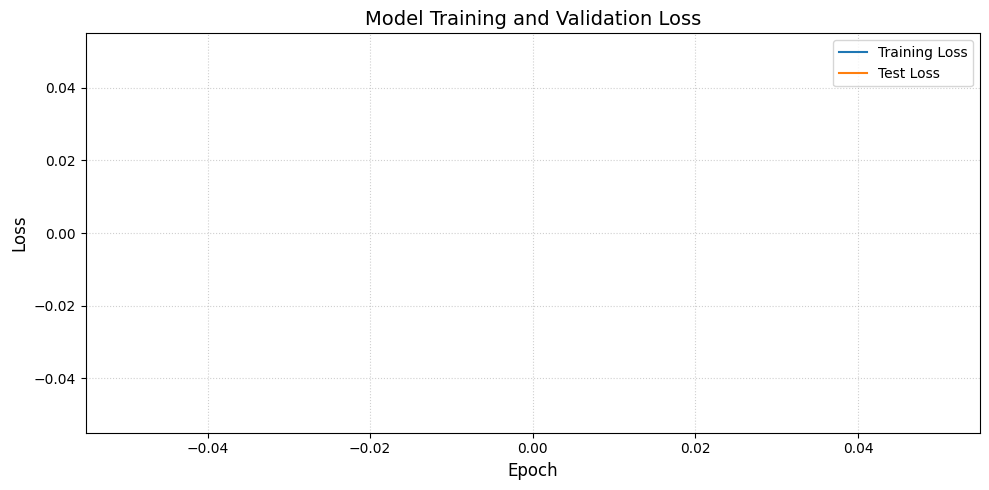

In [28]:
stable_epoch = 1
end_epoch = len(training_loss_values)

epoch_axis = range(0, end_epoch)


#  plot training curve
plt.figure(figsize=(10, 5))
plt.plot(epoch_axis,  training_loss_values, label='Training Loss')
plt.plot(epoch_axis, testing_loss_values, label='Test Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Model Training and Validation Loss', fontsize=14)
plt.legend()
plt.xlim()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
#adjust scale 
''''
max_plot_loss = max(training_loss_values[stable_epoch:])*1.1
min_plot_loss = min(training_loss_values[stable_epoch:])*0.7
plt.ylim(min_plot_loss,max_plot_loss)
'''
plt.show()




## Looper

In [ ]:
# Configuration
model_name = 'parallel_conv_classifier' # remember to change this! 
selected_model = ConvMultiClassifierV2_Mod3().to(device)

report_dir = Path(f'../reports/final_results/{model_name}_results')
shift_values = [0,1,2,3,4,5]
max_broadening_sigma = 2.0
valence_range = 40



loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-4)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # Check if all 39 classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()  # Use .all(axis=1) to check all classes
    acc = (correct / len(y_true)) * 100  # Calculate accuracy as a percentage
    return acc

# Create report directory structure
report_dir.mkdir(parents=True, exist_ok=True)

# Initialize results dataframe
results = []


for max_shift in shift_values:
    print(f"\n{'='*50}")
    print(f"Training with max_shift = {max_shift} eV")
    print(f"{'='*50}")
    
    # Process data with current shift value
    train_loader, test_loader, input_features, output_features = process_spectra_data(
        spectra_dir='../data/synthetic_data_final/synthetic_spectra',
        labels_dir='../data/synthetic_data_final/synthetic_labels',
        max_shift=max_shift,
        max_broadening_sigma=max_broadening_sigma,
        valence_range=0,  #valence region is already removed in saved data,
        energy_resolution=0.1,
        test_size=0.2,
        random_state=42,
        batch_size=64
    )
    
    model_0 = selected_model #re-initialises model for training at each shift 
    optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-4)
    # Train model
    training_info = train_model(
        model=model_0,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        epochs=1000,
        print_freq=100
    )
    
    # Create shift-specific directory
    shift_dir = report_dir / f'shift_{max_shift}eV'
    shift_dir.mkdir(exist_ok=True)
    
    # Save training curves
    pd.DataFrame({
        'epoch': range(len(training_info['train_loss'])),
        'train_loss': training_info['train_loss'],
        'test_loss': training_info['test_loss'],
        'train_acc': training_info['train_acc'],
        'test_acc': training_info['test_acc']
    }).to_csv(shift_dir / 'training_curves.csv', index=False)

    trained_model = training_info['model']
    
    # Evaluate on test set
    trained_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = trained_model(X_batch).squeeze()
            preds = torch.round(torch.sigmoid(logits))
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    
    y_test_np = np.concatenate(all_labels)
    test_pred_np = np.concatenate(all_preds)
    
    # Calculate metrics
    accuracy = accuracy_fn(y_test_np, test_pred_np)
    
    # Compute class metrics
    metrics_df, cms, norm_cms = compute_class_metrics(
        y_true=y_test_np,
        y_pred=test_pred_np,
        class_names=FG_list  # Your list of functional group names
    )

    # Save confusion matrix results in shift-specific directory
    metrics_df.to_csv(shift_dir / 'class_metrics.csv', index=False)

    # Save raw confusion matrices
    np.save(shift_dir / 'confusion_matrices.npy', np.array(cms))

    # Save normalized confusion matrices
    np.save(shift_dir / 'normalized_confusion_matrices.npy', np.array(norm_cms))

    # Add confusion matrix summary to results dict
    results.append({
        'shift_value': max_shift,
        'final_train_loss': training_info['train_loss'][-1],
        'final_test_loss': training_info['test_loss'][-1],
        'final_train_acc': training_info['train_acc'][-1],
        'final_test_acc': training_info['test_acc'][-1],
        'aggregate_val_accuracy': accuracy,
        'mean_precision': metrics_df['precision'].mean(),
        'mean_recall': metrics_df['recall'].mean(),
        'mean_f1': metrics_df['f1_score'].mean()
    })


# Save comprehensive results
results_df = pd.DataFrame(results)
results_df.to_csv(report_dir / 'all_results_summary.csv', index=False)

print("\nAll experiments completed. Results saved to:", report_dir)


Training with max_shift = 0 eV
Epoch:    0 | Train Loss: 0.69858, Acc: 0.00% | Test Loss: 0.60775, Acc: 0.00%
Early stopping at epoch 94

Training with max_shift = 1 eV
Epoch:    0 | Train Loss: 0.07964, Acc: 41.23% | Test Loss: 2.72757, Acc: 0.15%


KeyboardInterrupt: 

In [23]:
model_0 = training_info['model']

# Save the Model

In [24]:
# Save the model
model_path = Path("/home/issa/new_project_clone/local_models") / f"best_STN_{max_shift}_shift.pth"
torch.save(model_0.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /home/issa/new_project_clone/local_models/best_STN_5_shift.pth


## Load Saved Model

In [19]:
# Create an instance of your model
saved_model  =MultiClassifierV1_STN().to(device)

# Define the path to the saved model
model_path = Path("/home/issa/new_project_clone/local_models") / f"STN_{max_shift}_shift.pth"

# Load the state dictionary
saved_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (if you're going to use it for inference)
saved_model.eval()

print(f"Model loaded from {model_path}")

Model loaded from /home/issa/new_project_clone/local_models/STN_3_shift.pth


## Load shifted test data

In [20]:
# Load the combined arrays
test_spectra_array = np.load('../data/test_data_final/test_spectra/test_spectra.npy')
test_labels_array = np.load('../data/test_data_final/test_labels/test_labels.npy')

# Convert to tensors (same as before)
test_spectra_tensor = torch.from_numpy(test_spectra_array)
test_labels_tensor = torch.from_numpy(test_labels_array)

# Access individual spectra (equivalent to your original CSV loading)
spectrum_index = 7  # Example: access the 8th spectrum
single_spectrum = test_spectra_array[spectrum_index]
single_label = test_labels_array[spectrum_index]

# Get shape information (same as before)
input_features = test_spectra_array.shape[1]  # Number of features per spectrum
output_features = test_labels_array.shape[1]  # Number of output classes

print(f"Input features per spectrum: {input_features}")
print(f"Output classes: {output_features}")
print(f"Spectrum {spectrum_index} shape: {single_spectrum.shape}")
print(f"Label {spectrum_index}: {single_label}")


Input features per spectrum: 6601
Output classes: 40
Spectrum 7 shape: (6601,)
Label 7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Testing

In [88]:
saved_model= model_0

In [21]:
test_spectra_tensor= test_spectra_tensor.to(device)
test_labels_tensor =test_labels_tensor.to(device)


print(test_spectra_tensor.shape)

# Now you can use these for evaluation
with torch.inference_mode():
    test_logits = saved_model(test_spectra_tensor)
    test_pred = torch.round(torch.sigmoid(test_logits))

y_test_np = test_labels_tensor.cpu().numpy()
test_pred_np = test_pred.cpu().numpy()


acc = accuracy_fn(y_test_np, test_pred_np)
print(f'regular accuracy {acc}%')

torch.Size([10000, 6601])
regular accuracy 83.94%


In [22]:
def create_uniform_energy_grid(start_energy, end_energy, increment=0.1):
    """
    Create a uniform energy grid with a fixed increment.
    
    Args:
        start_energy: Starting energy value.
        end_energy: Ending energy value.
        increment: Energy increment (default is 0.1 eV).
    
    Returns:
        energy_range: Uniform energy grid as a NumPy array.
    """
    return np.arange(start_energy, end_energy + increment, increment)

valence_region_index =400 
start_energy, end_energy = (0,700)

BE_values = create_uniform_energy_grid(start_energy, end_energy)[valence_region_index:]

regular accuracy 83.65%


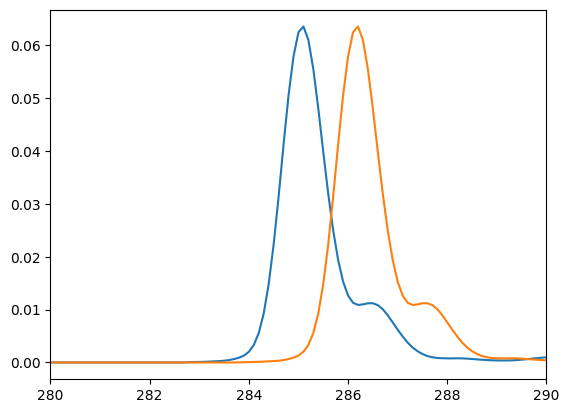

In [23]:

test_spectra_np= test_spectra_tensor.cpu().numpy()
test_labels_np = test_labels_tensor.cpu().numpy()

aligned_test_spectra = []
for test_spectrum in test_spectra_np:
    aligned_test_spectrum, _ = shift_to_reference(test_spectrum, 
                                                   carbon_region = (280.5, 289.5),  # eV range
                                                    reference_peak_eV = 285.1)
    aligned_test_spectra.append(aligned_test_spectrum)

example_shifted =aligned_test_spectra[0]
example_unshifted = test_spectra_np[0]


plt.plot(BE_values, example_shifted)
plt.plot(BE_values, example_unshifted)
plt.xlim(280,290)
plt.show

# Start of Selection
aligned_test_spectra_tensor = torch.stack([torch.from_numpy(arr) for arr in aligned_test_spectra]).to(device)

# Now you can use these for evaluation
with torch.inference_mode():
    test_logits = saved_model(aligned_test_spectra_tensor)
    test_preds = torch.round(torch.sigmoid(test_logits))

test_preds_np = test_preds.cpu().numpy()
acc = accuracy_fn(test_preds_np, test_labels_np)
print(f'regular accuracy {acc}%')


In [28]:

def print_class_confusion_matrices(y_true, y_pred, class_names=None):
    """
    Print normalized confusion matrices for each class individually,
    handling cases where classes might be empty.
    
    Args:
        y_true: True labels (n_samples × n_classes)
        y_pred: Predicted labels (n_samples × n_classes)
        class_names: Optional list of class names
    """
    n_classes = y_true.shape[1]
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    
    # Initialize DataFrame to store performance metrics
    metrics_df = pd.DataFrame(columns=['Class', 'TP', 'TN', 'FP', 'FN', 
                                     'Precision', 'Recall', 'F1', 'Support'])
    
    for i in range(n_classes):
        # Ensure we always consider both classes (0 and 1) even if empty
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = tp + fn
        
        # Store metrics
        metrics_df.loc[i] = [
            class_names[i],
            tp, tn, fp, fn,
            f"{precision:.3f}",
            f"{recall:.3f}",
            f"{f1:.3f}",
            support
        ]
        
        # Normalize by true labels (rows)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        print(f"\n{class_names[i]} Confusion Matrix (Normalized by True Labels):")
        print(f"Actual\Predicted | Negative | Positive")
        print("-"*40)
        print(f"Negative         | {cm_normalized[0,0]:5.1f}%   | {cm_normalized[0,1]:5.1f}%")
        print(f"Positive         | {cm_normalized[1,0]:5.1f}%   | {cm_normalized[1,1]:5.1f}%")
    
    # Print summary metrics
    print("\n\nClassification Metrics Summary:")
    print(metrics_df.to_string(index=False))
    
    return metrics_df

<>:44: SyntaxWarning: invalid escape sequence '\P'
<>:44: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_2562669/566775622.py:44: SyntaxWarning: invalid escape sequence '\P'
  print(f"Actual\Predicted | Negative | Positive")


In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score

metrics = print_class_confusion_matrices(
    y_true=test_labels_np,
    y_pred=test_preds_np,
    class_names= FG_list  # Custom names if available
)


alkene Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         |  99.6%   |   0.4%
Positive         |  22.8%   |  77.2%

alkyne Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         | 100.0%   |   0.0%
Positive         |   nan%   |   nan%

benzene ring Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         |  99.0%   |   1.0%
Positive         |   4.3%   |  95.7%

naphthalene Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         | 100.0%   |   0.0%
Positive         |  12.2%   |  87.8%

amine Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         |  99.9

/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 10

In [49]:
torch.manual_seed(42)


# Set the number of epochs
epochs = 10000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    epoch_loss = 0  # Track loss for the entire epoch

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # 1. Forward pass (model outputs raw logits)
        y_logits = model_0(X_batch).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_batch)
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        total_loss += loss.item() * len(y_batch)  # Accumulate loss for the epoch, scaled by batch size

        correct = (y_batch == y_pred).all(axis=1).sum().item()  # Calculate correct predictions for the batch
        total_correct += correct  # Accumulate correct predictions for the epoch
        total_samples += len(y_batch)  # Accumulate total samples for the epoch

    # Calculate average loss and accuracy for the epoch
    epoch_loss = total_loss / total_samples
    epoch_acc = (total_correct / total_samples) * 100  # Calculate accuracy as a percentage
    training_loss_values.append(epoch_loss)
    

    ### Testing
    model_0.eval()
    total_test_loss = 0  # Initialize total test loss
    total_correct = 0  # Initialize total correct predictions
    total_samples = 0  # Initialize total samples

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            # Move data to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # 1. Forward pass
            test_logits = model_0(X_batch).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))

            # 2. Calculate loss/accuracy
            test_loss = loss_fn(test_logits, y_batch)
            total_test_loss += test_loss.item() * len(y_batch)  # Accumulate loss for the epoch

            correct = (y_batch == test_pred).all(axis=1).sum().item()  # Calculate correct predictions for the batch
            total_correct += correct  # Accumulate correct predictions
            total_samples += len(y_batch)  # Accumulate total samples

    # Calculate average test loss and accuracy
    average_test_loss = total_test_loss / total_samples
    test_acc = (total_correct / total_samples) * 100  # Calculate accuracy as a percentage
    testing_loss_values.append(average_test_loss)

    # Check for early stopping
    early_stopping(average_test_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break
    
    # Update best test loss and accuracy
    if average_test_loss < best_test_loss:
        best_test_loss = average_test_loss
        best_test_acc = test_acc
        best_epoch = epoch

    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {epoch_acc:.2f}% | Test loss: {average_test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.15216, Accuracy: 24.24% | Test loss: 0.15108, Test acc: 31.85%
Epoch: 1 | Loss: 0.10079, Accuracy: 35.05% | Test loss: 0.09913, Test acc: 38.35%
Epoch: 2 | Loss: 0.07524, Accuracy: 41.24% | Test loss: 0.07980, Test acc: 43.79%
Epoch: 3 | Loss: 0.07141, Accuracy: 46.21% | Test loss: 0.06741, Test acc: 49.17%
Epoch: 4 | Loss: 0.05782, Accuracy: 50.85% | Test loss: 0.06049, Test acc: 54.25%
Epoch: 5 | Loss: 0.06705, Accuracy: 55.06% | Test loss: 0.05441, Test acc: 58.35%
Epoch: 6 | Loss: 0.04441, Accuracy: 58.02% | Test loss: 0.04867, Test acc: 60.81%
Epoch: 7 | Loss: 0.05746, Accuracy: 60.70% | Test loss: 0.04661, Test acc: 63.10%
Epoch: 8 | Loss: 0.05391, Accuracy: 62.51% | Test loss: 0.04262, Test acc: 65.38%
Epoch: 9 | Loss: 0.04555, Accuracy: 64.59% | Test loss: 0.04070, Test acc: 66.36%
Epoch: 10 | Loss: 0.04707, Accuracy: 66.00% | Test loss: 0.03841, Test acc: 68.66%
Epoch: 11 | Loss: 0.04632, Accuracy: 66.78% | Test loss: 0.03709, Test acc: 69.66%
Epoch: 12 | Lo

KeyboardInterrupt: 

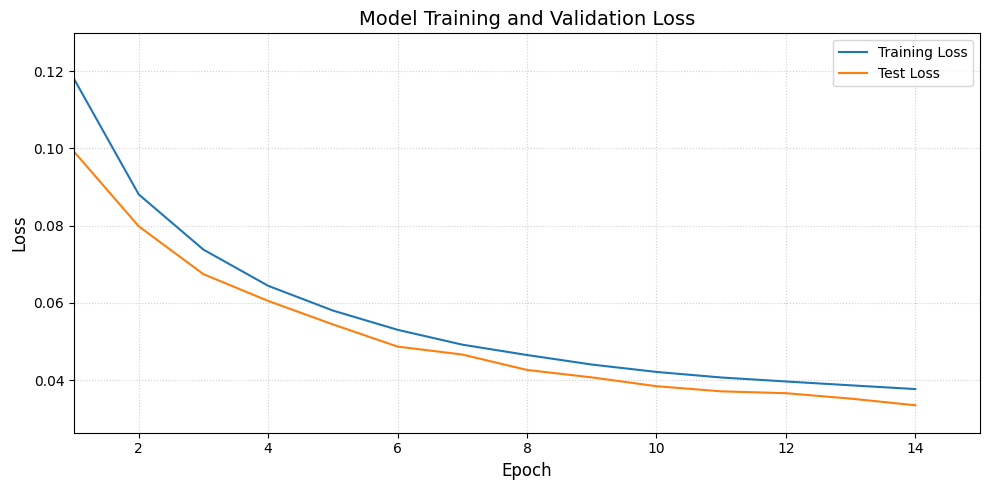

In [73]:
stable_epoch = 1
end_epoch = len(training_loss_values)

epoch_axis = range(0, end_epoch)



#  plot training curve
plt.figure(figsize=(10, 5))
plt.plot(epoch_axis, training_loss_values, label='Training Loss')
plt.plot(epoch_axis, testing_loss_values, label='Test Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Model Training and Validation Loss', fontsize=14)
plt.legend()
plt.xlim(stable_epoch, end_epoch)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
#adjust scale 
max_plot_loss = max(training_loss_values[stable_epoch:])*1.1
min_plot_loss = min(training_loss_values[stable_epoch:])*0.7
plt.ylim(min_plot_loss,max_plot_loss)
plt.savefig(f"../reports/multi_class_models/conv_NN/{max_shift}_shift.png")
plt.show()




# Testing

In [36]:
# 4. Create an instance of the model and send it to target device
model_0 = MultiClassifierV1().to(device)

# Load the saved model
model_path = Path("../models/multi_class_models/no_shift_v0.pth")
model_0.load_state_dict(torch.load(model_path))
model_0.eval()

X_test = X_test.to(device)

# Generate predictions using the loaded model
with torch.inference_mode():
    test_logits = model_0(X_test).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))


FileNotFoundError: [Errno 2] No such file or directory: '../models/multi_class_models/no_shift_v0.pth'

In [39]:
model_0.eval()

X_test = X_test.to(device)

# Generate predictions using the loaded model
with torch.inference_mode():
    test_logits = model_0(X_test).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))

In [40]:
# Print predictions and logits for index 1
index = 3
print("\nPredictions vs Logits vs Labels for index", index)
print("-" * 65)
print(f"{'Logit':<15} {'Prediction':<15} {'True Label':<15}")
print("-" * 65)
for logit, pred, label in zip(test_logits[index], test_pred[index], y_test[index]):
    print(f" {logit.item():<15.4f} {pred.item():<15.4f} {label.item():<15.4f}")


Predictions vs Logits vs Labels for index 3
-----------------------------------------------------------------
Logit           Prediction      True Label     
-----------------------------------------------------------------
 0.0593          1.0000          0.0000         
 0.0003          1.0000          0.0000         
 0.0224          1.0000          0.0000         
 -0.0594         0.0000          0.0000         
 -0.0281         0.0000          0.0000         
 0.0613          1.0000          0.0000         
 -0.0172         0.0000          0.0000         
 -0.0512         0.0000          0.0000         
 0.1004          1.0000          0.0000         
 0.0728          1.0000          0.0000         
 -0.0275         0.0000          0.0000         
 -0.0766         0.0000          0.0000         
 0.0255          1.0000          0.0000         
 -0.0538         0.0000          0.0000         
 -0.0050         0.0000          0.0000         
 -0.0086         0.0000          0.0000 

In [17]:
from sklearn.metrics import recall_score
import numpy as np
import os
import pandas as pd 
from tabulate import tabulate

def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

data_path = Path("../data/experimental_data")
CEL_FG_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx')
FG_list = get_label_dict(CEL_FG_path)
FG_list.append('alkane')

y_test_np = y_test.cpu().numpy()
test_pred_np = test_pred.cpu().numpy()

report_array = []  # New array for sensitivity values

# Calculate sensitivity for each class and total frequency
for i in range(39):  # Assuming 39 classes
    # Check if the class has positive samples in the test data
    if np.sum(y_test_np[:, i]) > 0:  # If there are positive samples
        sensitivity = recall_score(y_test_np[:, i], test_pred_np[:, i], average=None)
        total_frequency = np.sum(bin_label_array[:, i])  # Count total occurrences of the class in the training data
        report_array.append([i, FG_list[i], sensitivity[1], total_frequency])  # Append class index, sensitivity value, total frequency, and functional group
    else:
        report_array.append([i, FG_list[i], None, 0])  # No sensitivity value for this class, frequency is 0, and functional group

# Calculate the average sensitivity value, ignoring empty entries
sensitivity_values = [row[2] for row in report_array if row[2] is not None]
average_sensitivity = np.mean(sensitivity_values)
    

print(tabulate(report_array, headers=['Class No.', 'Functional Group', 'Sensitivity', 'Total Frequency', ]))
print(f"\nAverage sensitivity (excluding classes with no data): {average_sensitivity:.2f}")

pd.DataFrame(report_array, columns=['Class No.', 'Functional Group', 'Sensitivity', 'Total Frequency']).to_csv('../reports/model0.csv', index=False)





  Class No.  Functional Group       Sensitivity    Total Frequency
-----------  -------------------  -------------  -----------------
          0  alkene                    0.856716               1739
          1  alkyne                                              0
          2  benzene ring              0.96881                8039
          3  naphthalene               0.75                    361
          4  amine                     0.949533               2569
          5  alcohol (aromatic)        0.793103                375
          6  alcohol (aliphatic)       0.840125               1448
          7  ether (aromatic)          0.938017               2471
          8  ether (aliphatic)         0.953913               5476
          9  alkyl halide (F)          0.989362               1882
         10  alkyl halide (Cl)         0.988764               1405
         11  alkyl halide (Br)                                   0
         12  alkyl halide (I)                                 

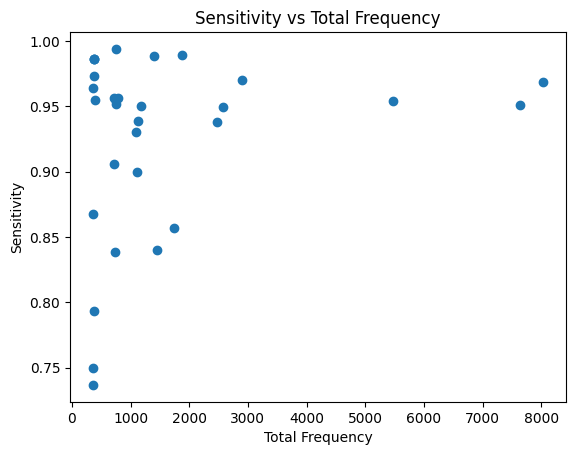

In [18]:
import matplotlib.pyplot as plt

# Extract sensitivity and total frequency from report_array
sensitivity_values = [row[2] for row in report_array if row[2] is not None]
total_frequencies = [row[3] for row in report_array if row[2] is not None]

# Plot sensitivity against total frequency
plt.scatter(total_frequencies, sensitivity_values)
plt.xlabel('Total Frequency')
plt.ylabel('Sensitivity')
plt.title('Sensitivity vs Total Frequency')
plt.savefig('../reports/sensitivity_vs_total_frequency.png')
plt.show()






In [72]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for each class
confusion_matrices = []
for i in range(39):  # Assuming 39 classes
    y_test_class = y_test_np[:, i]
    test_pred_class = test_pred_np[:, i]
    confusion_matrix_class = confusion_matrix(y_test_class, test_pred_class)
    confusion_matrices.append(confusion_matrix_class)

# Print the confusion matrix for each class
for i, matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Class {i}:")
    print(matrix)

Confusion Matrix for Class 0:
[[3715    4]
 [ 107  174]]
Confusion Matrix for Class 1:
[[4000]]
Confusion Matrix for Class 2:
[[2682    5]
 [ 139 1174]]
Confusion Matrix for Class 3:
[[3933    0]
 [  32   35]]
Confusion Matrix for Class 4:
[[3601    2]
 [  68  329]]
Confusion Matrix for Class 5:
[[3938    0]
 [  28   34]]
Confusion Matrix for Class 6:
[[3787    1]
 [  77  135]]
Confusion Matrix for Class 7:
[[3601    5]
 [ 104  290]]
Confusion Matrix for Class 8:
[[3149   10]
 [ 119  722]]
Confusion Matrix for Class 9:
[[3693    0]
 [   9  298]]
Confusion Matrix for Class 10:
[[3778    0]
 [  16  206]]
Confusion Matrix for Class 11:
[[4000]]
Confusion Matrix for Class 12:
[[4000]]
Confusion Matrix for Class 13:
[[4000]]
Confusion Matrix for Class 14:
[[4000]]
Confusion Matrix for Class 15:
[[3956    0]
 [  17   27]]
Confusion Matrix for Class 16:
[[3838    1]
 [  50  111]]
Confusion Matrix for Class 17:
[[3850    0]
 [  50  100]]
Confusion Matrix for Class 18:
[[2734   30]
 [ 157 1079]

/root/GenXPS/genXPS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/root/GenXPS/genXPS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/root/GenXPS/genXPS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/root/GenXPS/genXPS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'

Visualizing a training sample:


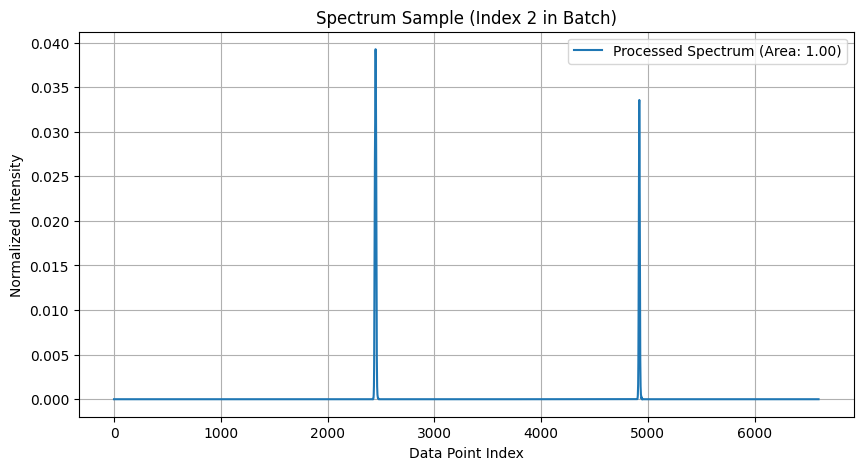


Visualizing a test sample:


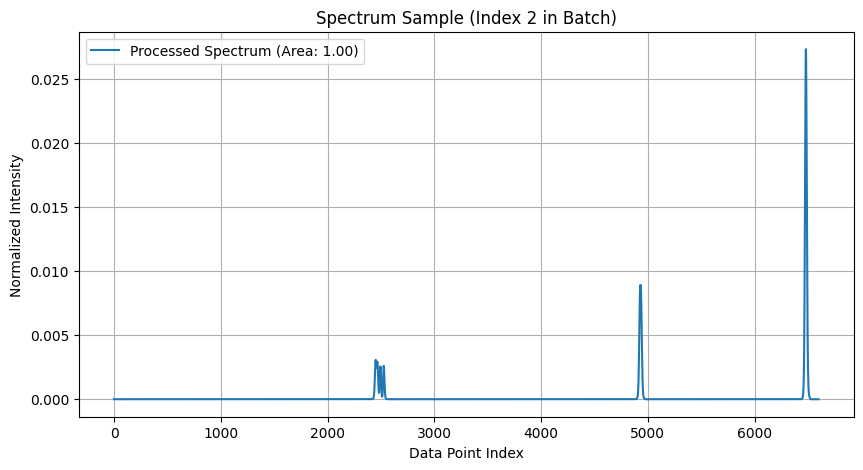

In [ ]:

def visualize_spectrum_from_dataloader(dataloader, sample_index):
    """
    Visualize a spectrum from a DataLoader.
    
    Args:
        dataloader (DataLoader): PyTorch DataLoader containing spectrum data
        sample_index (int): Index of the sample to visualize within a batch
    """
    # Get one batch of data
    X_batch, y_batch = next(iter(dataloader))
    
    # Convert the selected spectrum to numpy array
    spectrum = X_batch[sample_index].cpu().numpy()
    
    # Calculate the area under the curve
    spectrum_area = np.sum(spectrum)
    
    # Plot the spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(spectrum, label=f'Processed Spectrum (Area: {spectrum_area:.2f})')
    plt.title(f'Spectrum Sample (Index {sample_index} in Batch)')
    plt.xlabel('Data Point Index')
    plt.ylabel('Normalized Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return spectrum


x =3
# Example usage:
print("Visualizing a training sample:")
train_spectrum = visualize_spectrum_from_dataloader(train_loader, x)

print("\nVisualizing a test sample:")
test_spectrum = visualize_spectrum_from_dataloader(test_loader, x)

In [ ]:
max_shift = 0
max_broadening_sigma = 2.0

#2.5 # max shift in eV
max_shift_index = int(max_shift/0.1) # max_shift converted to index value for shifting 1d sequential data  

valence_range = 40 #range for core electron binding energy peaks eV
valence_region_index= int(valence_range/0.1)


# prepare list of file paths for file handeling
spectra_dir = Path('../data/synthetic_data_full/synthetic_spectra')
labels_dir = Path('../data/synthetic_data_full/synthetic_labels')

all_spectra = [spectra_dir / file for file in os.listdir(spectra_dir)]
all_labels = [labels_dir / file for file in os.listdir(labels_dir)]

#extracting synthetic spectrum data and converting to tensor
all_spectra.sort(key=lambda x: int(x.stem.split('_')[1]))
spectrum_list = []
for spectra_path in all_spectra:
    spectrum_df = pd.read_csv(spectra_path)
    spectrum = spectrum_df.values.flatten()  # Convert DataFrame to 1D array
    shifted_spectrum = apply_horizontal_shift(spectrum, max_shift_index)  # Apply the shift
    shifted_spectrum = shifted_spectrum[valence_region_index:]  # Exclude the valence region
    shifted_spectrum = np.maximum(shifted_spectrum, 0)  # Replace negative values with zero
    normalized_spectrum = np.array(normalize_spectra_by_area(shifted_spectrum))
    broadened_spectrum = gaussian_broadening(normalized_spectrum,max_broadening_sigma)
    spectrum_df = pd.DataFrame(broadened_spectrum)
    spectrum_list.append(spectrum_df)


spectrum_array = np.array(spectrum_list).squeeze()
spectrum_tensor = torch.tensor(spectrum_array, dtype=torch.float32)

#extracting synthetic label data and converting to tensor
all_labels.sort(key=lambda x: int(x.stem.split('_')[1]))
label_list = []
for label_path in all_labels:
    label_df = pd.read_csv(label_path)

    label_list.append(label_df)

label_array = np.array(label_list).squeeze()
bin_label_array = np.array([fg_checker(i) for i in label_array])


label_tensor = torch.tensor(bin_label_array,dtype=torch.float32)

print(spectrum_tensor.shape)
print(label_tensor.shape)


#split into traning/testing batches

X_train, X_test, y_train, y_test = train_test_split(spectrum_tensor, 
                                                    label_tensor, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

input_features = spectrum_tensor.shape[1]
output_features = label_tensor.shape[1]

print(input_features,output_features)

# Create Tensor datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Set your desired batch size
batch_size = 64  # Adjust this value as needed

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([50000, 6601])
torch.Size([50000, 40])
6601 40
